In [1]:
# Install Gurobi if not already installed
# !pip install gurobipy
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum


In [2]:
# Load customer locations
customer_df = pd.read_csv('customer_locations.csv')
# Assuming the columns are: 'CustomerID', 'x', 'y'

# Load warehouse locations
warehouse_df = pd.read_csv('warehouse_locations.csv')
# Assuming the columns are: 'WarehouseID', 'x', 'y'

# Load supply data
supply_df = pd.read_csv('supply.csv')

# Rename the first column in warehouse_df
warehouse_df.rename(columns={warehouse_df.columns[0]: 'WarehouseID'}, inplace=True)

# Rename the first column in supply_df
supply_df.rename(columns={supply_df.columns[0]: 'WarehouseID'}, inplace=True)

# Merge warehouse locations with supply data
warehouse_df = pd.merge(warehouse_df, supply_df, on='WarehouseID')


In [3]:
#Rename for clarity and consistency
customer_df.columns = ['CustomerID', 'x', 'y']
warehouse_df.columns = ['WarehouseID', 'x', 'y', 'Supply']


In [4]:
# Create dictionaries for warehouse and customer coordinates
warehouse_coords = warehouse_df.set_index('WarehouseID')[['x', 'y']].to_dict('index')
customer_coords = customer_df.set_index('CustomerID')[['x', 'y']].to_dict('index')

# Create a list of warehouse and customer IDs
warehouses = warehouse_df['WarehouseID'].tolist()
customers = customer_df['CustomerID'].tolist()

# Compute distances and store in a dictionary
distances = {}
for i in warehouses:
    for j in customers:
        xi, yi = warehouse_coords[i]['x'], warehouse_coords[i]['y']
        xj, yj = customer_coords[j]['x'], customer_coords[j]['y']
        distance = np.hypot(xi - xj, yi - yj)
        distances[(i, j)] = distance


Question 1. Assume that each delivery driver can complete only one delivery per day. One delivery here
refers to a one-way trip from one location to another. Additionally, each driver can start their route from
any warehouse. For this question, the demand may not be fully satisfied for a particular day, but we must
try to satisfy it as much as our capacity allows. The objective is to match the drivers to the customers
minimizing the total distance traveled by the drivers. We let dij represent the Euclidean distance between
warehouse i ∈ M and customer j ∈ N . You are asked to:
1) Formulate an optimization model in general form (using dij , si, etc. instead of the values in the
dataset) through a linear program.
2) Solve this optimization problem on the dataset we provide using Gurobi and print out the final
delivery schedule you find assuming k = 6.

# Question 1, (2): Solving the model

In [5]:
# Initialize the model
model = Model('DeliveryOptimization')

# Decision variables: x_{ij} = 1 if warehouse i delivers to customer j
x = model.addVars(warehouses, customers, vtype=GRB.BINARY, name='x')

# Number of drivers available
k = 6 #min(customer_df['CustomerID'].count(), warehouse_df['Supply'].sum())

# Constraints now follow

# 1. Total deliveries cannot exceed the number of drivers
model.addConstr(quicksum(x[i, j] for i in warehouses for j in customers) <= k, name='DriverLimit')

# 2. Each warehouse cannot exceed its supply
for i in warehouses:
    supply = warehouse_df.loc[warehouse_df['WarehouseID'] == i, 'Supply'].iloc[0]
    model.addConstr(quicksum(x[i, j] for j in customers) <= supply, name=f'Supply_{i}')

# 3. Each customer receives at most one delivery
for j in customers:
    model.addConstr(quicksum(x[i, j] for i in warehouses) <= 1, name=f'Demand_{j}')

# First Stage: Maximize total deliveries
model.setObjective(quicksum(x[i, j] for i in warehouses for j in customers), GRB.MAXIMIZE)

# Optimize
model.optimize()

# Check for optimality
if model.status == GRB.OPTIMAL:
    max_deliveries = model.objVal
    print('')
    print('Maximum number of deliveries:', max_deliveries)
    print('')

    # Add constraint that total deliveries equal max_deliveries
    model.addConstr(quicksum(x[i, j] for i in warehouses for j in customers) == max_deliveries, name='MaxDeliveries')

    # Now, set objective to minimize total distance
    model.setObjective(quicksum(distances[i, j] * x[i, j] for i in warehouses for j in customers), GRB.MINIMIZE)

    # Optimize again
    model.optimize()

    # Extract solution 
    if model.status == GRB.OPTIMAL:
        delivery_schedule = []
        for i in warehouses:
            for j in customers:
                if x[i, j].X > 0.5:
                    delivery_schedule.append({
                        'WarehouseID': i,
                        'CustomerID': j,
                        'Distance': distances[i, j]
                    })
        delivery_df = pd.DataFrame(delivery_schedule)
        print('')
        print('')
        print('Final Delivery Schedule:')
        print(delivery_df)
    else:
        print('No optimal solution found in the second optimization.')
else:
    print('No optimal solution found in the first optimization.')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26 rows, 100 columns and 300 nonzeros
Model fingerprint: 0xcc029745
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 26 rows and 100 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+00, best bound 6

Question 3. Reformulate the problem introduced in Question 2 by adjusting the linear program as a min-cost flow problem. This may require introducing additional integer constraints. In this problem, assume the
following: 1. Drivers will start from a warehouse and will not visit any warehouse again on their delivery
path. 2. Each customer will be visited by no more than one driver. 3. The demand must be satisfied. 4.
There are k drivers. You are asked to:
1) Formulate the optimization problem as an integer program
2) Solve the resulting optimization problem on the provided dataset using Gurobi, assuming k = 6.
3) Provide the final optimal delivery schedule and briefly describe it.

# Question 3

In [6]:
# Load customer locations
customer_df = pd.read_csv('customer_locations.csv')
customer_df.columns = ['NodeID', 'x', 'y']
customer_df['Type'] = 'Customer'

# Prefix customer IDs
customer_df['NodeID'] = 'C_' + customer_df['NodeID'].astype(str)

# Load warehouse locations
warehouse_df = pd.read_csv('warehouse_locations.csv')
warehouse_df.columns = ['NodeID', 'x', 'y']
warehouse_df['Type'] = 'Warehouse'

# Prefix warehouse IDs
warehouse_df['NodeID'] = 'W_' + warehouse_df['NodeID'].astype(str)

# Load supply data
supply_df = pd.read_csv('supply.csv')
supply_df.columns = ['NodeID', 'Supply']

# Prefix warehouse IDs in supply data
supply_df['NodeID'] = 'W_' + supply_df['NodeID'].astype(str)

# Merge warehouse locations with supply data
warehouse_df = pd.merge(warehouse_df, supply_df, on='NodeID')

# Combine all nodes
nodes_df = pd.concat([warehouse_df, customer_df], ignore_index=True)
nodes = nodes_df['NodeID'].tolist()
node_indices = {node_id: idx for idx, node_id in enumerate(nodes)}

# Create sets
warehouses = warehouse_df['NodeID'].tolist()
customers = customer_df['NodeID'].tolist()

In [7]:
# Compute distances between all nodes
coords = nodes_df[['x', 'y']].values
distances = {}
num_nodes = len(nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            node_i = nodes[i]
            node_j = nodes[j]
            distance = np.hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])
            distances[node_i, node_j] = distance

In [8]:
# Initialize the model
model = Model('DeliveryOptimization')

# Parameters
k = 6  # Number of drivers
Q = 5   # Maximum capacity per driver

# z_{ij}: Binary variables for routes from nodes to customers (i != j)
z_indices = [(i, j) for i in nodes for j in customers if i != j]
z = model.addVars(z_indices, vtype=GRB.BINARY, name='z')

# y_{ij}: Continuous variables for flows from nodes to customers (i != j)
y_indices = [(i, j) for i in nodes for j in customers if i != j]
y = model.addVars(y_indices, lb=0, ub=Q, vtype=GRB.INTEGER, name='y')

# Objective Function: Minimize total distance traveled by drivers
model.setObjective(
    quicksum(distances[i, j] * z[i, j] for (i, j) in z_indices),
    GRB.MINIMIZE
)

for w in warehouses:
    supply = warehouse_df.loc[warehouse_df['NodeID'] == w, 'Supply'].iloc[0]
    model.addConstr(
        quicksum(y[w, j] for j in customers if w != j and (w, j) in y_indices) <= supply,
        name=f'Supply_{w}'
    )
    
for j in customers:
    inflow = quicksum(y[i, j] for i in nodes if i != j and (i, j) in y_indices)
    outflow = quicksum(y[j, k] for k in customers if k != j and (j, k) in y_indices)
    model.addConstr(inflow == outflow + 1, name=f'FlowConservation_{j}')
    
model.addConstr(
    quicksum(z[w, j] for w in warehouses for j in customers if (w, j) in z_indices) <= k,
    name='DriverLimit'
)

for j in customers:
    model.addConstr(
        quicksum(z[i, j] for i in nodes if i != j and (i, j) in z_indices) == 1,
        name=f'IncomingRoute_{j}'
    )
    
for i in customers:
    model.addConstr(
        quicksum(z[i, j] for j in customers if i != j and (i, j) in z_indices) <= 1,
        name=f'OutgoingRoute_{i}'
    )
    
for (i, j) in z_indices:
    model.addConstr(y[i, j] >= z[i, j], name=f'FlowLowerBound_{i}_{j}')
    model.addConstr(y[i, j] <= Q * z[i, j], name=f'FlowUpperBound_{i}_{j}')
    
# Optimize the model
model.optimize()

if model.status == GRB.OPTIMAL:
    print('Optimal solution found.')
    routes = []
    for (i, j) in z_indices:
        if z[i, j].X > 0.5:
            routes.append({
                'From': i,
                'To': j,
                'Distance': distances[i, j]
            })
    routes_df = pd.DataFrame(routes)
    print('Final Delivery Schedule:')
    print(np.round(routes_df, 2))
else:
    print('No optimal solution found.')


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1026 rows, 960 columns and 3840 nonzeros
Model fingerprint: 0x25104f2e
Variable types: 0 continuous, 960 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 7e+00]
Presolve time: 0.01s
Presolved: 1026 rows, 960 columns, 3840 nonzeros
Variable types: 0 continuous, 960 integer (480 binary)

Root relaxation: objective 2.716829e+02, 567 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  271.68291    0   35          -  271.68291      -     -    0s
     0     0  283.69602    0   

## Question 4: Looping from k=4 to 10


Solving for k = 4 drivers
Total distance traveled: 372.49

Solving for k = 5 drivers
Total distance traveled: 316.20

Solving for k = 6 drivers
Total distance traveled: 300.22

Solving for k = 7 drivers
Total distance traveled: 296.56

Solving for k = 8 drivers
Total distance traveled: 293.87

Solving for k = 9 drivers
Total distance traveled: 291.50

Solving for k = 10 drivers
Total distance traveled: 289.19


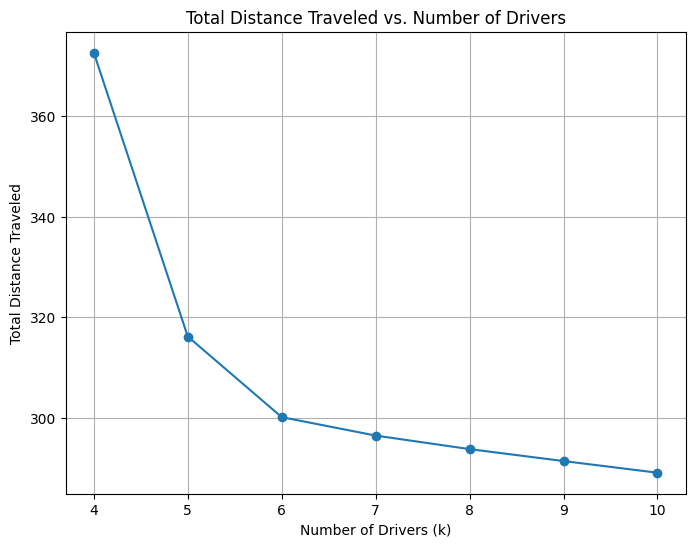

In [9]:
# Load customer locations
customer_df = pd.read_csv('customer_locations.csv', dtype={'NodeID': str})
customer_df.columns = ['NodeID', 'x', 'y']
customer_df['Type'] = 'Customer'

# Prefix customer IDs
customer_df['NodeID'] = 'C_' + customer_df['NodeID'].astype(str)

# Load warehouse locations
warehouse_df = pd.read_csv('warehouse_locations.csv', dtype={'NodeID': str})
warehouse_df.columns = ['NodeID', 'x', 'y']
warehouse_df['Type'] = 'Warehouse'

# Prefix warehouse IDs
warehouse_df['NodeID'] = 'W_' + warehouse_df['NodeID'].astype(str)

# Load supply data
supply_df = pd.read_csv('supply.csv', dtype={'NodeID': str})
supply_df.columns = ['NodeID', 'Supply']

# Prefix warehouse IDs in supply data
supply_df['NodeID'] = 'W_' + supply_df['NodeID'].astype(str)

# Merge warehouse locations with supply data
warehouse_df = pd.merge(warehouse_df, supply_df, on='NodeID')

# Combine all nodes
nodes_df = pd.concat([warehouse_df, customer_df], ignore_index=True)
nodes = nodes_df['NodeID'].tolist()
node_indices = {node_id: idx for idx, node_id in enumerate(nodes)}

# Create sets
warehouses = warehouse_df['NodeID'].tolist()
customers = customer_df['NodeID'].tolist()

# Compute distances between all nodes
coords = nodes_df[['x', 'y']].values
distances = {}
num_nodes = len(nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            node_i = nodes[i]
            node_j = nodes[j]
            distance = np.hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])
            distances[node_i, node_j] = distance

# Parameters
Q = 5   # Maximum capacity per driver

# Lists to store results
k_values = list(range(4, 11))  # k from 4 to 10
total_distances = []

for k in k_values:
    print(f"\nSolving for k = {k} drivers")
    # Initialize the model
    model = Model('DeliveryOptimization')
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Decision Variables
    # z_{ij}: Binary variables for routes from nodes to customers (i != j)
    z_indices = [(i, j) for i in nodes for j in customers if i != j]
    z = model.addVars(z_indices, vtype=GRB.BINARY, name='z')

    # y_{ij}: Continuous variables for flows from nodes to customers (i != j)
    y_indices = [(i, j) for i in nodes for j in customers if i != j]
    y = model.addVars(y_indices, lb=0, vtype=GRB.CONTINUOUS, name='y')

    # Objective Function: Minimize total distance traveled by drivers
    model.setObjective(
        quicksum(distances[i, j] * z[i, j] for (i, j) in z_indices),
        GRB.MINIMIZE
    )

    # Constraints

    # 1. Warehouse Supply Constraints
    for w in warehouses:
        supply = warehouse_df.loc[warehouse_df['NodeID'] == w, 'Supply'].iloc[0]
        model.addConstr(
            quicksum(y[w, j] for j in customers if w != j and (w, j) in y_indices) <= supply,
            name=f'Supply_{w}'
        )

    # 2. Flow Conservation at Customer Nodes
    for j in customers:
        inflow = quicksum(y[i, j] for i in nodes if i != j and (i, j) in y_indices)
        outflow = quicksum(y[j, k] for k in customers if k != j and (j, k) in y_indices)
        model.addConstr(inflow == outflow + 1, name=f'FlowConservation_{j}')

    # 3. Driver Assignment Constraint
    model.addConstr(
        quicksum(z[w, j] for w in warehouses for j in customers if (w, j) in z_indices) <= k,
        name='DriverLimit'
    )

    # 4. Each Customer is Assigned Exactly One Incoming Route
    for j in customers:
        model.addConstr(
            quicksum(z[i, j] for i in nodes if i != j and (i, j) in z_indices) == 1,
            name=f'IncomingRoute_{j}'
        )

    # 5. Each Customer Has At Most One Outgoing Route
    for i in customers:
        model.addConstr(
            quicksum(z[i, j] for j in customers if i != j and (i, j) in z_indices) <= 1,
            name=f'OutgoingRoute_{i}'
        )

    # 6. Relationship Between Route and Flow Variables
    for (i, j) in z_indices:
        model.addConstr(y[i, j] >= z[i, j], name=f'FlowLowerBound_{i}_{j}')
        model.addConstr(y[i, j] <= Q * z[i, j], name=f'FlowUpperBound_{i}_{j}')

    # Optimize the model
    model.optimize()

    # Check if an optimal solution was found
    if model.status == GRB.OPTIMAL:
        total_distance = model.ObjVal
        total_distances.append(total_distance)
        print(f"Total distance traveled: {total_distance:.2f}")
    else:
        total_distances.append(None)
        print("No optimal solution found.")

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(k_values, total_distances, marker='o')
plt.title('Total Distance Traveled vs. Number of Drivers')
plt.xlabel('Number of Drivers (k)')
plt.ylabel('Total Distance Traveled')
plt.grid(True)
plt.show()

## Question 5: Drivers start from their homes


In [25]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum

# Load customer locations
customer_df = pd.read_csv('customer_locations.csv', dtype={'NodeID': str})
customer_df.columns = ['NodeID', 'x', 'y']
customer_df['Type'] = 'Customer'
customer_df['NodeID'] = 'C_' + customer_df['NodeID'].astype(str)

# Load warehouse locations
warehouse_df = pd.read_csv('warehouse_locations.csv', dtype={'NodeID': str})
warehouse_df.columns = ['NodeID', 'x', 'y']
warehouse_df['Type'] = 'Warehouse'
warehouse_df['NodeID'] = 'W_' + warehouse_df['NodeID'].astype(str)

# Load supply data
supply_df = pd.read_csv('supply.csv', dtype={'NodeID': str})
supply_df.columns = ['NodeID', 'Supply']
supply_df['NodeID'] = 'W_' + supply_df['NodeID'].astype(str)

# Merge warehouse locations with supply data
warehouse_df = pd.merge(warehouse_df, supply_df, on='NodeID')

# Load driver locations
driver_df = pd.read_csv('driver_locations.csv', dtype={'NodeID': str})
driver_df.columns = ['NodeID', 'x', 'y']
driver_df['NodeID'] = 'D_' + driver_df['NodeID'].astype(str)

# Combine all nodes
nodes_df = pd.concat([warehouse_df, customer_df], ignore_index=True)
nodes = nodes_df['NodeID'].tolist()

# Create sets
warehouses = warehouse_df['NodeID'].tolist()
customers = customer_df['NodeID'].tolist()
drivers = driver_df['NodeID'].tolist()

# Compute distances between drivers and warehouses
driver_to_warehouse_distances = {}
for d in drivers:
    for w in warehouses:
        dx, dy = driver_df.loc[driver_df['NodeID'] == d, ['x', 'y']].iloc[0]
        wx, wy = warehouse_df.loc[warehouse_df['NodeID'] == w, ['x', 'y']].iloc[0]
        driver_to_warehouse_distances[d, w] = np.hypot(dx - wx, dy - wy)

# Compute distances between all nodes
coords = nodes_df[['x', 'y']].values
distances = {}
num_nodes = len(nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            node_i = nodes[i]
            node_j = nodes[j]
            distance = np.hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])
            distances[node_i, node_j] = distance

# Initialize the model
model = Model('DeliveryOptimization_Bonus')
model.setParam('OutputFlag', 0)  # Suppress Gurobi output

# Parameters
k = 6  # Fixed number of drivers
Q = 5  # Maximum capacity per driver

# Decision Variables
a_indices = [(d, w) for d in drivers for w in warehouses]
a = model.addVars(a_indices, vtype=GRB.BINARY, name='a')  # Driver-to-warehouse assignment

z_indices = [(i, j) for i in nodes for j in customers if i != j]
z = model.addVars(z_indices, vtype=GRB.BINARY, name='z')  # Routes between nodes and customers

y_indices = [(i, j) for i in nodes for j in customers if i != j]
y = model.addVars(y_indices, lb=0, vtype=GRB.CONTINUOUS, name='y')  # Flows between nodes and customers

# Objective Function: Minimize total distance
model.setObjective(
    quicksum(driver_to_warehouse_distances[d, w] * a[d, w] for (d, w) in a_indices) +  # Driver-to-warehouse
    quicksum(distances[i, j] * z[i, j] for (i, j) in z_indices),  # Node-to-node
    GRB.MINIMIZE
)

# Constraints

# 1. Warehouse Supply Constraints
for w in warehouses:
    supply = warehouse_df.loc[warehouse_df['NodeID'] == w, 'Supply'].iloc[0]
    model.addConstr(
        quicksum(y[w, j] for j in customers if (w, j) in y_indices) <= supply,
        name=f'Supply_{w}'
    )

# 2. Flow Conservation at Customer Nodes
for j in customers:
    inflow = quicksum(y[i, j] for i in nodes if (i, j) in y_indices)
    outflow = quicksum(y[j, k] for k in customers if (j, k) in y_indices)
    model.addConstr(inflow == outflow + 1, name=f'FlowConservation_{j}')

# 3. Driver Assignment Constraint
model.addConstr(
    quicksum(z[w, j] for w in warehouses for j in customers if (w, j) in z_indices) <= k,
    name='DriverLimit'
)

# 4. Each Customer is Assigned Exactly One Incoming Route
for j in customers:
    model.addConstr(
        quicksum(z[i, j] for i in nodes if (i, j) in z_indices) == 1,
        name=f'IncomingRoute_{j}'
    )

# 5. Each Customer Has At Most One Outgoing Route
for i in customers:
    model.addConstr(
        quicksum(z[i, j] for j in customers if (i, j) in z_indices) <= 1,
        name=f'OutgoingRoute_{i}'
    )

# 6. Relationship Between Route and Flow Variables
for (i, j) in z_indices:
    model.addConstr(y[i, j] >= z[i, j], name=f'FlowLowerBound_{i}_{j}')
    model.addConstr(y[i, j] <= Q * z[i, j], name=f'FlowUpperBound_{i}_{j}')

# 7. At Most One Driver Assigned to Each Driver Location (Home)
for d in drivers:
    model.addConstr(
        quicksum(a[d, w] for w in warehouses if (d, w) in a_indices) <= 1,
        name=f'DriverToWarehouse_{d}'
    )

# 8. Driver-Warehouse Consistency Constraint
for w in warehouses:
    model.addConstr(
        quicksum(a[d, w] for d in drivers if (d, w) in a_indices) ==
        quicksum(z[w, j] for j in customers if (w, j) in z_indices),
        name=f'DriverWarehouseConsistency_{w}'
    )

# 9. Prevent Drivers from Returning to Their Homes After Deliveries
for d in drivers:
    model.addConstr(
        quicksum(z[j, d] for j in nodes if (j, d) in z_indices) == 0,
        name=f'NoReturnToHome_{d}'
    )

# Optimize the model
model.optimize()

# Check if an optimal solution was found
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found.\n")
else:
    print("No optimal solution found.")


Optimal Solution Found.



In [29]:
# Extract Driver-to-Warehouse Assignments
print("Driver to Warehouse Assignments:")
driver_to_warehouse_routes = []
for (d, w) in a_indices:
    if a[d, w].X > 0.5:  # If the variable is active
        driver_to_warehouse_routes.append({
            'DriverID': d,
            'WarehouseID': w,
            'Distance': driver_to_warehouse_distances[d, w]
        })

driver_to_warehouse_df = pd.DataFrame(driver_to_warehouse_routes)
print(driver_to_warehouse_df)

# Extract Warehouse-to-Customer Routes
print("\nWarehouse to Customer Routes:")
warehouse_to_customer_routes = []
for (i, j) in z_indices:
    if z[i, j].X > 0.5:  # If the variable is active
        warehouse_to_customer_routes.append({
            'From': i,
            'To': j,
            'Distance': distances[i, j]
        })

warehouse_to_customer_df = pd.DataFrame(warehouse_to_customer_routes)
print(warehouse_to_customer_df)

# Optional: Total Distance
total_driver_to_warehouse_distance = driver_to_warehouse_df['Distance'].sum()
total_warehouse_to_customer_distance = warehouse_to_customer_df['Distance'].sum()
total_distance = total_driver_to_warehouse_distance + total_warehouse_to_customer_distance

print("\nTotal Distance Traveled:")
print(f"Driver to Warehouse Distance: {total_driver_to_warehouse_distance:.2f}")
print(f"Warehouse to Customer Distance: {total_warehouse_to_customer_distance:.2f}")
print(f"Total Distance: {total_distance:.2f}")


Driver to Warehouse Assignments:
  DriverID WarehouseID   Distance
0      D_1         W_4  99.968366
1      D_3         W_3  42.357929
2      D_4         W_0  86.536531
3      D_5         W_2  82.699063

Warehouse to Customer Routes:
    From    To   Distance
0    W_0   C_5   7.071313
1    W_2   C_6  25.925735
2    W_3  C_18   7.355335
3    W_4  C_11  13.633290
4    C_0  C_13  24.302517
5    C_1   C_9  21.224476
6    C_2   C_4  21.415727
7    C_3  C_14  25.709365
8    C_5   C_0  16.147602
9    C_6   C_3  17.052441
10   C_7   C_8  34.169803
11   C_9   C_2  15.407520
12  C_10  C_16  21.508415
13  C_11   C_1  11.979675
14  C_13   C_7  31.414585
15  C_14  C_10  14.124074
16  C_15  C_17  19.921827
17  C_17  C_12  25.843004
18  C_18  C_19   8.562221
19  C_19  C_15   9.723754

Total Distance Traveled:
Driver to Warehouse Distance: 311.56
Warehouse to Customer Distance: 372.49
Total Distance: 684.05


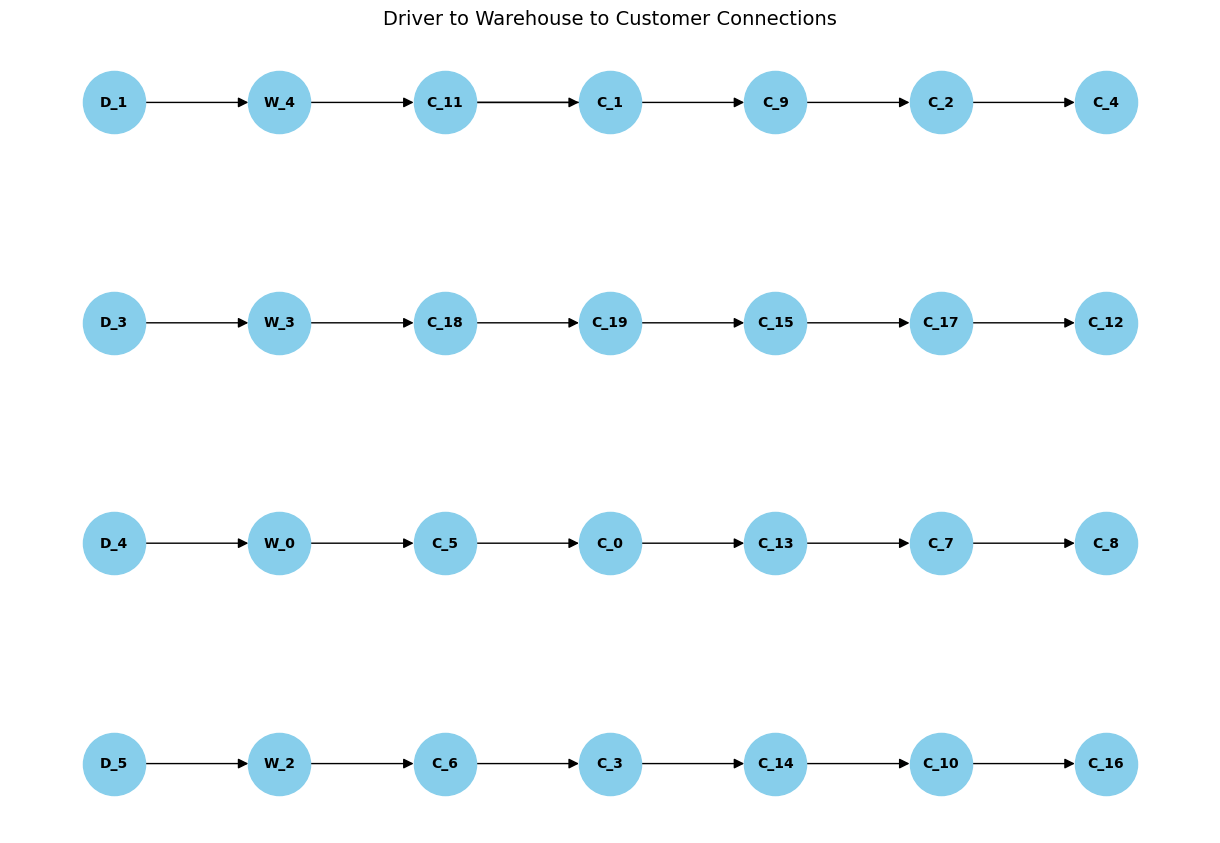

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the routes
routes = [
    ("D_1", "W_4"),
    ("W_4", "C_11"),
    ("C_11", "C_1"),
    ("C_11", "C_9"),
    ("C_9", "C_2"),
    ("C_2", "C_4"),
    ("D_3", "W_3"),
    ("W_3", "C_18"),
    ("C_18", "C_19"),
    ("C_19", "C_15"),
    ("C_15", "C_17"),
    ("C_17", "C_12"),
    ("D_4", "W_0"),
    ("W_0", "C_5"),
    ("C_5", "C_0"),
    ("C_0", "C_13"),
    ("C_13", "C_7"),
    ("C_7", "C_8"),
    ("D_5", "W_2"),
    ("W_2", "C_6"),
    ("C_6", "C_3"),
    ("C_3", "C_14"),
    ("C_14", "C_10"),
    ("C_10", "C_16")
]

# Create a directed graph
G = nx.DiGraph()
G.add_edges_from(routes)

# Define positions for straight-line layout
positions = {}
y = 0  # Starting y-coordinate for lines
x_offset = 1  # Horizontal spacing
driver_routes = {}  # Group routes by driver

# Group the routes by driver
for start, end in routes:
    if start.startswith("D"):
        current_driver = start
        if current_driver not in driver_routes:
            driver_routes[current_driver] = []
    driver_routes[current_driver].append((start, end))

# Assign positions for each route
for driver, edges in driver_routes.items():
    x = 0
    for edge in edges:
        start, end = edge
        if start not in positions:
            positions[start] = (x, y)
        if end not in positions:
            x += x_offset
            positions[end] = (x, y)
    y -= 1  # Move to the next line for a new driver

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos=positions, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.title("Driver to Warehouse to Customer Connections", fontsize=14)
plt.show()
